In [95]:
#import libraries
import pandas as pd
import pymongo
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import text
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Create Connection to postgres

In [96]:
conn = psycopg2.connect(database="postgres", user='postgres', password='postgres', host='127.0.0.1', port='5432')
conn.autocommit = True

### Create Database in postgres

In [97]:
cursor = conn.cursor()
create_database_sql = open('Create DB.sql','r')
cursor.execute(create_database_sql.read())

#If no error print message
print("Database created successfully........")

#Closing the connection
conn.close()

Database created successfully........


## Store CSV into DataFrame

In [98]:
csv_file = "../ETL-Project/data/archive/beers.csv"
beers_df = pd.read_csv(csv_file)
beers_df.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [99]:
csv_file = "../ETL-Project/data/archive/breweries.csv"
breweries_df = pd.read_csv(csv_file)
breweries_df.head()

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [100]:
breweries_df.rename(columns = {'Unnamed: 0':'brewery_id', 'name':'brewery_name'}, inplace = True) 
breweries_df.head()


,brewery_id,brewery_name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [101]:
breweries_df.set_index("brewery_id")

,brewery_name,city,state
brewery_id,,,
0,NorthGate Brewing,Minneapolis,MN
1,Against the Grain Brewery,Louisville,KY
2,Jack's Abby Craft Lagers,Framingham,MA
3,Mike Hess Brewing Company,San Diego,CA
4,Fort Point Beer Company,San Francisco,CA
...,...,...,...
553,Covington Brewhouse,Covington,LA
554,Dave's Brewfarm,Wilson,WI
555,Ukiah Brewing Company,Ukiah,CA


In [102]:
breweries_df.state = breweries_df.state.str.lstrip()
breweries_df

,brewery_id,brewery_name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
...,...,...,...,...
553,553,Covington Brewhouse,Covington,LA
554,554,Dave's Brewfarm,Wilson,WI
555,555,Ukiah Brewing Company,Ukiah,CA
556,556,Butternuts Beer and Ale,Garrattsville,NY


In [103]:
#drop columns in beer_df
beers_df = beers_df.drop(columns=['Unnamed: 0', 'ibu'])
#beers_df.head()

In [104]:
beers_df.rename(columns = {'id':'beer_id', 'name':'beer_name'}, inplace = True) 

In [105]:
beers_df.set_index("beer_id")

,abv,beer_name,style,brewery_id,ounces
beer_id,,,,,
1436,0.050,Pub Beer,American Pale Lager,408,12.0
2265,0.066,Devil's Cup,American Pale Ale (APA),177,12.0
2264,0.071,Rise of the Phoenix,American IPA,177,12.0
2263,0.090,Sinister,American Double / Imperial IPA,177,12.0
2262,0.075,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...
928,0.067,Belgorado,Belgian IPA,424,12.0
807,0.052,Rail Yard Ale,American Amber / Red Ale,424,12.0
620,0.055,B3K Black Lager,Schwarzbier,424,12.0


## Build Schema in SQL

In [106]:
conn = psycopg2.connect(database="beer_db", user='postgres', password='postgres', host='127.0.0.1', port='5432')
conn.autocommit = True
cursor = conn.cursor()

In [107]:
schema_sql = open('Schema Build.sql','r')
cursor.execute(schema_sql.read())
print("Database Schema Loaded Successfully (Tables Created)........")


Database Schema Loaded Successfully (Tables Created)........


## Create connection for Load operation

In [108]:
#Use sqlalchemy to facilitate the load process
connection_string = "postgres:postgres@localhost:5432/beer_db"
engine = create_engine(f'postgresql://{connection_string}')

In [109]:
# Confirm tables
engine.table_names()

['brewery', 'beers']

### Load the DF into Postgres using Pandas

In [110]:
breweries_df.to_sql(name='brewery', con=engine, if_exists='append', index=False)

In [111]:
beers_df.to_sql(name='beers', con=engine, if_exists='append', index=False)

## Begin Select statements on the new database

In [112]:
join_sql = open('Join 1.sql','r')
brewery_and_state_df = pd.read_sql_query(join_sql.read(), con=engine)
brewery_and_state_df

,brewery_name,state,beer_name
0,King Street Brewing Company,AK,King Street IPA
1,Kenai River Brewing Company,AK,Skilak Scottish Ale
2,Broken Tooth Brewing Company,AK,Fairweather IPA
3,Broken Tooth Brewing Company,AK,Chugach Session Ale
4,Broken Tooth Brewing Company,AK,Polar Pale Ale
...,...,...,...
2405,Wind River Brewing Company,WY,Wind River Blonde Ale
2406,Snake River Brewing Company,WY,Monarch Pilsner
2407,Snake River Brewing Company,WY,Snow King Pale Ale
2408,Snake River Brewing Company,WY,Zonker Stout


In [113]:
select_sql = open('Select 1.sql','r')
beer_styles_df = pd.read_sql_query(select_sql.read(), con=engine)
beer_styles_df

,style,abv,brewery_id
0,Abbey Single Ale,0.049,57
1,Abbey Single Ale,0.049,57
2,Altbier,0.052,25
3,Altbier,0.050,122
4,Altbier,0.055,490
...,...,...,...
2405,None,0.060,160
2406,None,NaN,166
2407,None,NaN,29
2408,None,0.053,66


In [114]:
#drop NaN from df
beer_styles_df = beer_styles_df.dropna(how='any')

#check to see if there are style names as 'none'
beer_styles_df.loc[beer_styles_df['style']=='None']

beer_styles_df

,style,abv,brewery_id
0,Abbey Single Ale,0.049,57
1,Abbey Single Ale,0.049,57
2,Altbier,0.052,25
3,Altbier,0.050,122
4,Altbier,0.055,490
...,...,...,...
2399,Witbier,0.048,440
2400,Witbier,0.050,288
2402,Witbier,0.046,128
2403,Witbier,0.050,225


## Bewery Count by State Bar Graph

In [115]:
brewery_state_count_df= brewery_and_state_df['state'].value_counts()
brewery_state_count_df.head(10)

CO    265
CA    183
MI    162
IN    139
TX    130
OR    125
PA    100
IL     91
WI     87
MA     82
Name: state, dtype: int64

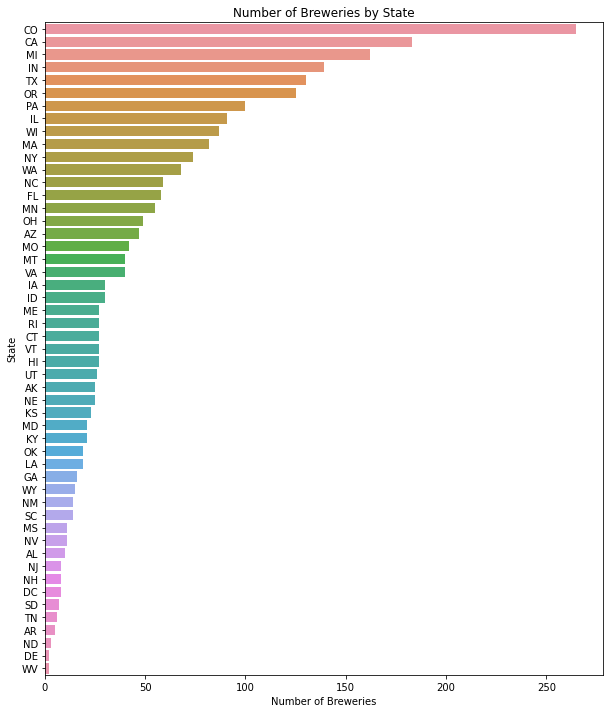

In [116]:
plt.figure(figsize=(10,12))
sns.barplot(y=brewery_state_count_df.index, x=brewery_state_count_df.values)
plt.title('Number of Breweries by State')
plt.xlabel('Number of Breweries')
plt.ylabel('State')
plt.yticks(rotation='horizontal')
plt.show()

## Most Popular Beer Style Bar Graph

In [117]:
beer_styles_count_df= beer_styles_df['style'].value_counts()

beer_styles_count_df.head(10)

American IPA                      417
American Pale Ale (APA)           239
American Amber / Red Ale          125
American Blonde Ale               104
American Double / Imperial IPA    103
American Pale Wheat Ale            95
American Brown Ale                 68
American Porter                    65
Saison / Farmhouse Ale             52
Witbier                            49
Name: style, dtype: int64

In [118]:
#beer_styles_abv_df = beer_styles_df.groupby(['style','abv']).mean()
beer_styles_abv_df = beer_styles_df.groupby(['style'])['abv'].mean()
beer_styles_abv_df


style
Abbey Single Ale              0.049000
Altbier                       0.054385
American Adjunct Lager        0.048722
American Amber / Red Ale      0.057456
American Amber / Red Lager    0.049464
                                ...   
Tripel                        0.086818
Vienna Lager                  0.051050
Wheat Ale                     0.060000
Winter Warmer                 0.070400
Witbier                       0.053551
Name: abv, Length: 99, dtype: float64

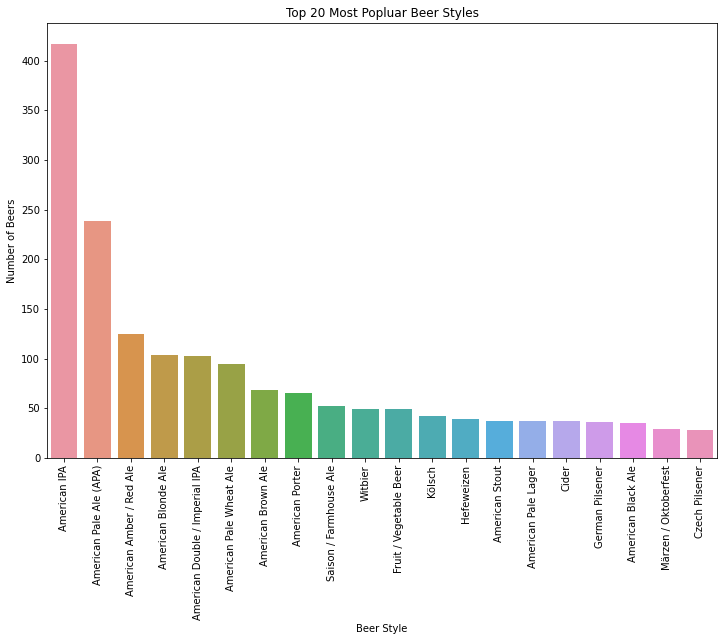

In [119]:
plt.figure(figsize=(12,8))
sns.barplot(x=beer_styles_count_df.nlargest(20).index, y=beer_styles_count_df.nlargest(20).values)
plt.title('Top 20 Most Popluar Beer Styles')
plt.ylabel('Number of Beers')
plt.xlabel('Beer Style')
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()



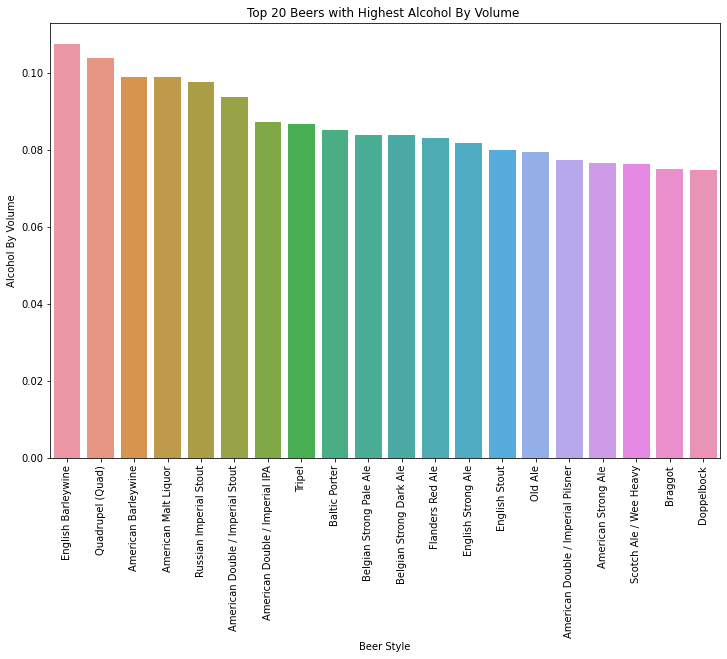

In [120]:
plt.figure(figsize=(12,8))
sns.barplot(x=beer_styles_abv_df.nlargest(20).index, y=beer_styles_abv_df.nlargest(20).values)
plt.title('Top 20 Beers with Highest Alcohol By Volume ')
plt.ylabel('Alcohol By Volume')
plt.xlabel('Beer Style')
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

In [121]:
#Dispose of the Connection to the Database
engine.dispose()
conn.close()